# Prakhar Jain
# 2022121008

Trained Models : https://drive.google.com/drive/folders/1E1pYtju_sBlSnodKjQa1b_uAq80xNbYN?usp=sharing

In [1]:
import unicodedata
import re
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import KeyedVectors
import nltk
from tqdm.auto import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download necessary NLTK data files
# nltk.download('punkt')

In [2]:

class TextProcessor:
    def __init__(self, file_path) -> None:
        self.file_path = file_path

    def clean_text(self, text):
        text = unicodedata.normalize("NFD", text)
        text = text.lower()
        text = re.sub(r"[^0-9a-zA-Z?.,!:;]+", r" ", text)
        text = re.sub(r"(.)\1{3,}", r"\1", text)
        text = text.strip()
        return text

    def preprocess_text(self):
        with open(self.file_path, 'r') as f:
            corpus = f.read()
        sentences = sent_tokenize(corpus)
        sentences = [self.clean_text(sent) for sent in sentences if not sent.lower(
        ).startswith('chapter') and not sent[0].isdigit()]
        return sentences

    def get_max_len(self, sentences):
        return max([len(word_tokenize(sent)) for sent in sentences])

    def generate_sentences(self, sentences):
        padded_sentences = []
        for sentence in sentences:
            tokens = word_tokenize(sentence)
            padded_sentence = ['<S>'] + tokens + ['</S>']
            padded_sentence = ' '.join(padded_sentence)
            padded_sentences.append(padded_sentence)
        return padded_sentences


class Vocabulary:
    def __init__(self, glove_path):
        self.glove_model = KeyedVectors.load_word2vec_format(
            glove_path, binary=False, no_header=True)
        self.word2idx = {}
        self.idx2word = []
        self.special_tokens = ['<PAD>', '<UNK>', '<S>', '</S>']
        self._add_special_tokens()

    def _add_special_tokens(self):
        for token in self.special_tokens:
            self.add_word(token)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)

    def build_vocab(self, sentences):
        for sentence in sentences:
            tokens = word_tokenize(sentence)
            for token in tokens:
                self.add_word(token)

    def get_glove_embeddings(self):
        embedding_dim = self.glove_model.vector_size
        embeddings = np.zeros((len(self.idx2word), embedding_dim))
        for idx, word in enumerate(self.idx2word):
            if word in self.glove_model:
                embeddings[idx] = self.glove_model[word]
            else:
                embeddings[idx] = np.random.normal(
                    scale=0.6, size=(embedding_dim,))
        return torch.tensor(embeddings, dtype=torch.float32)

    def index2word(self, idx):
        return self.idx2word[idx]

    def word2index(self, word):
        return self.word2idx.get(word, self.word2idx['<UNK>'])

    def __len__(self):
        return len(self.word2idx)


class TextDatasetTransformer(Dataset):
    def __init__(self, sentences, vocab, max_len):
        self.sentences = sentences
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx].split()
        if len(sentence) > self.max_len:
            sentence = sentence[:self.max_len]
        input_idxs = [self.vocab.word2index(word) for word in sentence[:-1]]
        target_idxs = [self.vocab.word2index(word) for word in sentence[1:]]

        return torch.tensor(input_idxs, dtype=torch.long), torch.tensor(target_idxs, dtype=torch.long)


def collate_fn(batch, padding_value):
    batch.sort(key=lambda x: len(x[0]), reverse=True)

    inputs, targets = zip(*batch)

    padded_inputs = pad_sequence(
        inputs, batch_first=True, padding_value=padding_value)
    padded_targets = pad_sequence(
        targets, batch_first=True, padding_value=padding_value)

    return padded_inputs, padded_targets

In [3]:
file_path = "Auguste_Maquet.txt"
glove_path = "glove.6B.300d.txt"

text_processor = TextProcessor(file_path)
sentences = text_processor.preprocess_text()

max_len = text_processor.get_max_len(sentences)

random.seed(42)
random.shuffle(sentences)

val_len = int(len(sentences) * 0.1)
test_len = int(len(sentences) * 0.2)

train_sentences = sentences[val_len + test_len:]
val_sentences = sentences[:val_len]
test_sentences = sentences[val_len:val_len + test_len]

vocabulary = Vocabulary(glove_path)
vocabulary.build_vocab(train_sentences)
embeddings = vocabulary.get_glove_embeddings()

train_sentences = text_processor.generate_sentences(train_sentences)
val_sentences = text_processor.generate_sentences(val_sentences)
test_sentences = text_processor.generate_sentences(test_sentences)

train_dataset = TextDatasetTransformer(train_sentences, vocabulary, max_len)
val_dataset = TextDatasetTransformer(val_sentences, vocabulary, max_len)
test_dataset = TextDatasetTransformer(test_sentences, vocabulary, max_len)

In [4]:

padding_value = vocabulary.word2index('<PAD>')

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=lambda batch: collate_fn(batch, padding_value))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=lambda batch: collate_fn(batch, padding_value))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=lambda batch: collate_fn(batch, padding_value))

In [5]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout, max_len):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.pos_embedding = nn.Embedding(max_len, embedding_dim)
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embedding_dim, vocab_size)

    # def generate_square_subsequent_masks(self, sz):
    #     return nn.Transformer.generate_square_subsequent_mask(sz)

    def forward(self, inputs):
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(inputs.size(1)).to(inputs.device)
        input_embedded = self.embedding(inputs) + self.pos_embedding(torch.arange(inputs.size(1)).unsqueeze(0).to(inputs.device))
        output = self.decoder(input_embedded, memory = input_embedded , tgt_mask=tgt_mask, memory_mask=tgt_mask)
        output = self.fc(output)
        return output

In [6]:
vocab_size = embeddings.shape[0]
embedding_dim = embeddings.shape[1]
hidden_dim = 512
num_layers = 6
num_heads = 6
dropout = 0.1
max_seq_len = max_len
padding_value = vocabulary.word2index('<PAD>')

In [7]:
model = TransformerDecoder(vocab_size, embedding_dim, hidden_dim,
                           num_layers, num_heads, dropout, max_seq_len).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=padding_value, reduction='sum')

In [8]:
# def generate_square_subsequent_mask(sz):
#     """
#     Generate a square mask for the sequence. The masked positions are filled with float('-inf').
#     Unmasked positions are filled with float(0.0).
#     """
#     mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#     mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#     return mask

In [9]:
def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_tokens = 0
    for inputs, targets in tqdm(dataloader, desc='Training...'):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_tokens += (targets != padding_value).sum().item()
    avg_loss = total_loss / total_tokens

    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.inference_mode():
        for inputs, targets in tqdm(dataloader, desc='Evaluating...'):
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()
            total_tokens += (targets != padding_value).sum().item()
    # avg_loss = total_loss / len(dataloader.dataset)
    avg_loss = total_loss / total_tokens
    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity

def test(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.inference_mode():
        for inputs, targets in tqdm(dataloader, desc='Testing...'):
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()
            total_tokens += (targets != padding_value).sum().item()
    avg_loss = total_loss / total_tokens
    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity

In [10]:
n_epochs = 10

for i in range(n_epochs):
    train_loss, train_perplexity = train_one_epoch(
        model, train_loader, criterion, optimizer, device)
    val_loss, val_perplexity = evaluate(model, val_loader, criterion, device)
    print(f'Epoch {i+1}/{n_epochs} => Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}')

test_loss, test_perplexity = test(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Perplexity: {test_perplexity:.4f}')

Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 1/10 => Train Loss: 5.8708, Train Perplexity: 354.5371, Val Loss: 5.3070, Val Perplexity: 201.7434


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 2/10 => Train Loss: 5.1467, Train Perplexity: 171.8557, Val Loss: 5.0238, Val Perplexity: 151.9914


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 3/10 => Train Loss: 4.9099, Train Perplexity: 135.6312, Val Loss: 4.8760, Val Perplexity: 131.1107


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 4/10 => Train Loss: 4.7499, Train Perplexity: 115.5782, Val Loss: 4.7766, Val Perplexity: 118.6981


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 5/10 => Train Loss: 4.6236, Train Perplexity: 101.8556, Val Loss: 4.7069, Val Perplexity: 110.7132


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 6/10 => Train Loss: 4.5161, Train Perplexity: 91.4808, Val Loss: 4.6491, Val Perplexity: 104.4948


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 7/10 => Train Loss: 4.4214, Train Perplexity: 83.2159, Val Loss: 4.6122, Val Perplexity: 100.7042


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 8/10 => Train Loss: 4.3331, Train Perplexity: 76.1804, Val Loss: 4.5800, Val Perplexity: 97.5152


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 9/10 => Train Loss: 4.2482, Train Perplexity: 69.9824, Val Loss: 4.5598, Val Perplexity: 95.5641


Training...:   0%|          | 0/1525 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 10/10 => Train Loss: 4.1690, Train Perplexity: 64.6486, Val Loss: 4.5429, Val Perplexity: 93.9611


Testing...:   0%|          | 0/436 [00:00<?, ?it/s]

Test Loss: 4.5373, Test Perplexity: 93.4371


In [11]:
torch.save(model.state_dict(), 'transformer_model.pth')

In [12]:
model = TransformerDecoder(vocab_size, embedding_dim, hidden_dim,
                            num_layers, num_heads, dropout, max_seq_len).to(device)
model.load_state_dict(torch.load('transformer_model.pth'))
criterion = nn.CrossEntropyLoss(ignore_index=padding_value, reduction='sum')


In [13]:

padding_value = vocabulary.word2index('<PAD>')

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=lambda batch: collate_fn(batch, padding_value))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=lambda batch: collate_fn(batch, padding_value))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=lambda batch: collate_fn(batch, padding_value))

In [14]:
# write perplexities of train, val and test sets to a . The format is sentence : perplexity

def write_perplexity_to_file(loader, model, criterion, device, file_path):
    with open(file_path, 'w') as f:
        for inputs, targets in tqdm(loader, desc='Writing Perplexities...'):
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output.view(-1, vocab_size), targets.view(-1))
            count = (targets != padding_value).sum().item()
            perplexity = calculate_perplexity(loss.item() / count)
            sentence = ' '.join([vocabulary.index2word(idx.item()) for idx in inputs[0]])
            f.write(f'{sentence} : {perplexity.item()}\n')

write_perplexity_to_file(train_loader, model, criterion, device, 'Lm-3-train.txt')
write_perplexity_to_file(val_loader, model, criterion, device, 'Lm-3-val.txt')
write_perplexity_to_file(test_loader, model, criterion, device, 'Lm-3-test.txt')

Writing Perplexities...:   0%|          | 0/24388 [00:00<?, ?it/s]

Writing Perplexities...:   0%|          | 0/3484 [00:00<?, ?it/s]

Writing Perplexities...:   0%|          | 0/6968 [00:00<?, ?it/s]

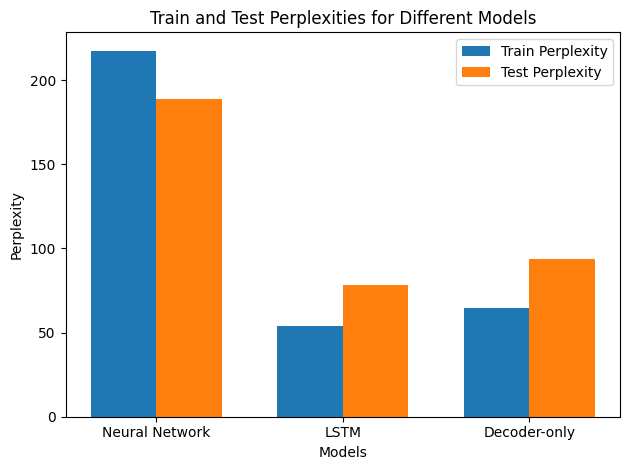

In [6]:
import matplotlib.pyplot as plt

# Data
models = ['Neural Network', 'LSTM', 'Decoder-only']
train_perplexities = [217.4456, 53.98, 64.6486]
test_perplexities = [188.6686, 78.29, 93.4371]

# Plotting the bar graph
bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots()
train_bar = ax.bar(index, train_perplexities, bar_width, label='Train Perplexity')
test_bar = ax.bar([i + bar_width for i in index], test_perplexities, bar_width, label='Test Perplexity')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Perplexity')
ax.set_title('Train and Test Perplexities for Different Models')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.savefig('perplexities.png')
plt.show()